# 03. Index Weighting & Formula

References:

Muscillo, A., Re, S., Gambacorta, S., Ferrara, G., Tagliafierro, N., Borello, E., Rubino, A., & Facchini, A. (2021). Circular City Index: An Open Data analysis to assess the urban circularity preparedness of cities to address the green transition -- A study on the Italian municipalities (arXiv:2109.10832). arXiv. https://doi.org/10.48550/arXiv.2109.10832 

In [1]:
import geopandas as gpd
import numpy as np
import os
import matplotlib.pyplot as plt

/root/venv/lib/python3.9/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/tmp/ipykernel_2268/535287306.py:3: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  im

In [2]:
# papermill parameters cell

OUTPUT_WARNINGS = False
SAVE_FIGS = True
SAVE_INDEX = True
ALTERNATIVE_KPI_WEIGHT = True # if False: original weightgs, but maximum value in thesis could be 0.76 instead of 1.0
ALTERNATIVE_AREA_COMPUTATION = True # if False: original area computation equations are used (W2 is strange defined)

In [3]:
if OUTPUT_WARNINGS is False:
    import warnings

    warnings.filterwarnings("ignore")

In [4]:
# create list with KPIs
KPI_list = [
    'D1',
    'D2',
    'D3',
    'D4',
    'ECR1',
    'ECR2',
    'ECR4',
    'ECR5',
    'M1',
    'M2',
    'M3',
    'M4',
    'W2',
    'W3'
]

### Data

In [5]:
# Data folders - input
INTERIM_FOLDER = 'data/interim/'
SPATIALIZED_FOLDER = "data/interim/Spatialization_interimdata/"
INDEX_FOLDER = "data/interim/Index_interimdata/"

In [6]:
# Datasets 
SPATIALIZED_INTERIMDATA = SPATIALIZED_FOLDER + 'CCI_spatialization_interimdata.gpkg'

## Parameter Check

In [7]:
# Create folders to store the data results
DIR_DATA = "data/"
DIR_VAR = DIR_DATA + "processed/{}/".format("CCI")
DIR_INDEX = DIR_VAR + "03_index/"

if SAVE_FIGS is True or SAVE_INDEX is True:
    folder_list = [INDEX_FOLDER, DIR_VAR, DIR_INDEX]

    for folder in folder_list:
        if not os.path.exists(folder):
            os.makedirs(folder)

## Preprocessing

In [8]:
# read spatialized dataset into geodataframe
gdf = gpd.read_file(SPATIALIZED_INTERIMDATA)
gdf.head()

,CTOT,CMUN,Municipality,D1,D2,D3,D4,ECR1,ECR2,ECR4,ECR5,M1,M2,M3,M4,W2,W3,POP21,geometry
0,1003124,03124,Sella,1.0,1.0,0.940154,0.538462,1.0,0.3,11.857143,4.625000,64863.137164,NaN,NaN,0.173010,24.919786,1.0,578.0,"MULTIPOLYGON (((-0.33310 38.62221, -0.33159 38..."
1,1003125,03125,Senija,1.0,1.0,0.857152,0.538462,1.0,0.6,14.666667,7.500000,140.277264,NaN,NaN,0.000000,47.108871,0.0,605.0,"MULTIPOLYGON (((0.02977 38.73416, 0.03122 38.7..."
2,1046224,46224,Segart,1.0,1.0,0.975460,0.307692,0.0,0.0,12.142857,13.000000,156.289531,NaN,NaN,0.000000,0.015979,0.0,177.0,"MULTIPOLYGON (((-0.39904 39.67404, -0.39887 39..."
3,0908222,08222,Sant Llorenç D'Hortons,1.0,0.0,0.965373,0.307692,1.0,0.6,17.428571,18.000000,164.738271,NaN,NaN,0.081334,97.650514,1.0,2459.0,"MULTIPOLYGON (((1.79248 41.47367, 1.79275 41.4..."
4,0908223,08223,Sant Llorenç Savall,1.0,0.0,0.967754,0.307692,0.0,0.0,13.268293,14.818182,NaN,NaN,NaN,0.039777,92.895522,1.0,2514.0,"MULTIPOLYGON (((2.01043 41.65840, 2.01065 41.6..."


In [9]:
# Fill NAN-values with 0.
gdf = gdf.fillna(0)

## Data Computation

### Benchmarks

In [10]:
# Define benchmark per KPI - Italian CCI
def bench(KPI):
    # Define benchmark per KPI
    if KPI == 'D1' or KPI == 'D2' or KPI == 'D3' or KPI == 'D4' or KPI == 'ECR1' or KPI == 'ECR2' or KPI == 'M2' or KPI == 'M4' or KPI == 'W3':
        return 1.0
    elif KPI == 'ECR3':
        return 0.55
    elif KPI == 'ECR4' or KPI == 'ECR5':
        return 40.0
    elif KPI == 'ECR6' or KPI == 'W1':
        return 0.0
    elif KPI == 'M1':
        return 900.0
    elif KPI == 'M3':
        return 100.0
    elif KPI == 'W2':
        return 0.0 # original 65.0
    else:
        pass

### Normalization - Area Values Computation

In [11]:
def normalization(KPI):
    standard_column_KPI = KPI + '_standardized'
    NON_STANDARD_VALUE = gdf[KPI]

    # 1. Binary values 
        ## Formula --> Skc = KPI * 1
        ## KPIs: ECR1, W3
    if KPI == 'D1' or KPI == 'D2' or KPI == 'D4' or KPI == 'ECR1' or KPI == 'ECR2'  or KPI == 'W3':
        gdf[standard_column_KPI] = NON_STANDARD_VALUE * 1.0

    # 2. Percentage values 
        ## Formula --> 
            ### If bench(KPI) > 0 --> Skc = KPI * bench(KPI)
            ### If bench(KPI) = 0 --> Skc = KPI − min (𝐾)/ (max(𝐾) − min(𝐾)), where K is the set of all KPIs collected for all the municipalities
        ## KPIs: D3, ECR3, ECR6, W2
    elif KPI == 'D3' or KPI == 'ECR3' or KPI == 'ECR6' or KPI == "W2":
        if bench(KPI) > 0.0:
            KPI_standard_percentage = NON_STANDARD_VALUE * bench(KPI)
        elif bench(KPI) == 0.0:
            KPI_standard_percentage = (NON_STANDARD_VALUE - NON_STANDARD_VALUE.min()) / (NON_STANDARD_VALUE.max() - NON_STANDARD_VALUE.min())

        gdf[standard_column_KPI] = KPI_standard_percentage
        
    # 3. Threshold_down values
        ## Formula --> Categorize KPI value into 5 intervals: 
            ### I1=[-1,0.5*bench(KPI)] --> score is I1=4
            ### I2=(0.5*bench(KPI),bench(KPI)];  --> score is I2=3
            ### I3=(bench(KPI),1.5*bench(KPI)];  --> score is I3=2
            ### I4=(1.5*bench(KPI),2*bench(KPI)]; --> score is I4=1
            ### I5=(2*bench(KPI),\inf) --> score is I5=0
        ### Normalization --> normalize threshold values through Skc = KPI − min (𝐾)/ (max(𝐾) − min(𝐾)), where K is the set of all KPIs collected for all the municipalities
        ## KPIs: ECR4, ECR5
    elif KPI == 'ECR4' or KPI == 'ECR5':
        column = []

        for i in NON_STANDARD_VALUE:
            if (i >= -1.0) & (i < 0.5 * bench(KPI)):
                column.append(4)
            elif (i >= 0.5 * bench(KPI)) & (i < bench(KPI)): 
                column.append(3)
            elif (i >= bench(KPI)) & (i < 1.5 * bench(KPI)):
                column.append(2)
            elif (i >= 1.5 * bench(KPI)) & (i < 2.0 * bench(KPI)): 
                column.append(1)
            elif (i >= 2.0 * bench(KPI)):
                column.append(0)
            else: 
                column.append(0)
        gdf[standard_column_KPI] = column
        
        # Normalize given threshold values
        gdf[standard_column_KPI] = (gdf[standard_column_KPI] - gdf[standard_column_KPI].min()) / (gdf[standard_column_KPI].max() - gdf[standard_column_KPI].min())  

    # 4. Threshold_up values
        ## Formula --> Skc = KPI / bench(KPI)
        ## KPIs: M1, M2, M3, M4
        ## Normalize data between Min and Max value (0-1).
    elif KPI == 'M1' or KPI == 'M2' or KPI == 'M3' or KPI == 'M4':
        KPI_standard_thresholdup = NON_STANDARD_VALUE / bench(KPI)
        gdf[standard_column_KPI] = KPI_standard_thresholdup
        gdf[standard_column_KPI].values[gdf[standard_column_KPI].values > 1.0] = 1.0
        # Normalize given threshold values
        #gdf[standard_column_KPI] = (gdf[standard_column_KPI] - gdf[standard_column_KPI].min()) / (gdf[standard_column_KPI].max() - gdf[standard_column_KPI].min())  

    # 5. Quartile_down values
        ## Use this one if a bench(KPI) mark is missing (e.g., production of solid waste per capita), and if the lower bracket values are targeted
        ## Formula --> Categorize KPI values into 4 quartiles of the KPIs values distribution: 
            ### Q1=4
            ### Q2=3
            ### Q3=1
            ### Q4=0
        ### Normalization --> normalize threshold values through Skc = KPI − min (𝐾)/ (max(𝐾) − min(𝐾)), where K is the set of all KPIs collected for all the municipalities
        ## KPIs: W1
    elif KPI == 'W1':
        column = []
        quartiles = np.quantile(NON_STANDARD_VALUE, [0.25,0.5,0.75])
        
        for i,j in enumerate(NON_STANDARD_VALUE):
            if NON_STANDARD_VALUE < quartiles[0]:
                column.append(4)
            elif quartiles[0] <= NON_STANDARD_VALUE < quartiles[1]:
                column.append(3)
            elif quartiles[1] <= NON_STANDARD_VALUE < quartiles[2]:
                column.append(1)
            elif quartiles[2] <= NON_STANDARD_VALUE:
                column.append(0)
            else:
                column.append(0)

        gdf[standard_column_KPI] = column

        # Normalize given threshold values
        gdf[standard_column_KPI] = (gdf[standard_column_KPI] - gdf[standard_column_KPI].min()) / (gdf[standard_column_KPI].max() - gdf[standard_column_KPI].min())  


    return gdf[standard_column_KPI]

In [12]:
def alternative_normalization(KPI):
    standard_column_KPI = KPI + '_standardized'
    NON_STANDARD_VALUE = gdf[KPI]

    # 1. Binary values 
        ## Formula --> Skc = KPI * 1
        ## KPIs: ECR1, W3
    if KPI == 'D1' or KPI == 'D2' or KPI == 'D4' or KPI == 'ECR1' or KPI == 'ECR2'  or KPI == 'W3':
        gdf[standard_column_KPI] = NON_STANDARD_VALUE * 1.0

    # 2. Percentage values 
        ## Formula --> 
            ### If bench(KPI) > 0 --> Skc = KPI * bench(KPI)
            ### If bench(KPI) = 0 --> Skc = KPI − min (𝐾)/ (max(𝐾) − min(𝐾)), where K is the set of all KPIs collected for all the municipalities
        ## KPIs: D3, ECR3, ECR6, W2
    elif KPI == 'D3' or KPI == 'ECR3' or KPI == 'ECR6':
        if bench(KPI) > 0.0:
            KPI_standard_percentage = NON_STANDARD_VALUE * bench(KPI)
        elif bench(KPI) == 0.0:
            KPI_standard_percentage = (NON_STANDARD_VALUE - NON_STANDARD_VALUE.min()) / (NON_STANDARD_VALUE.max() - NON_STANDARD_VALUE.min())

        gdf[standard_column_KPI] = KPI_standard_percentage
        
    # 3. Threshold_down values
        ## Formula --> Categorize KPI value into 5 intervals: 
            ### I1=[-1,0.5*bench(KPI)] --> score is I1=4
            ### I2=(0.5*bench(KPI),bench(KPI)];  --> score is I2=3
            ### I3=(bench(KPI),1.5*bench(KPI)];  --> score is I3=2
            ### I4=(1.5*bench(KPI),2*bench(KPI)]; --> score is I4=1
            ### I5=(2*bench(KPI),\inf) --> score is I5=0
        ### Normalization --> normalize threshold values through Skc = KPI − min (𝐾)/ (max(𝐾) − min(𝐾)), where K is the set of all KPIs collected for all the municipalities
        ## KPIs: ECR4, ECR5
    elif KPI == 'ECR4' or KPI == 'ECR5':
        column = []

        for i in NON_STANDARD_VALUE:
            if (i >= -1.0) & (i < 0.5 * bench(KPI)):
                column.append(4)
            elif (i >= 0.5 * bench(KPI)) & (i < bench(KPI)): 
                column.append(3)
            elif (i >= bench(KPI)) & (i < 1.5 * bench(KPI)):
                column.append(2)
            elif (i >= 1.5 * bench(KPI)) & (i < 2.0 * bench(KPI)): 
                column.append(1)
            elif (i >= 2.0 * bench(KPI)):
                column.append(0)
            else: 
                column.append(0)
        gdf[standard_column_KPI] = column
        
        # Normalize given threshold values
        gdf[standard_column_KPI] = (gdf[standard_column_KPI] - gdf[standard_column_KPI].min()) / (gdf[standard_column_KPI].max() - gdf[standard_column_KPI].min())  

    # 4. Threshold_up values
        ## Formula --> Skc = KPI / bench(KPI)
        ## KPIs: M1, M2, M3, M4
        ## Normalize data between Min and Max value (0-1).
    elif KPI == 'M1' or KPI == 'M2' or KPI == 'M3' or KPI == 'M4':
        KPI_standard_thresholdup = NON_STANDARD_VALUE / bench(KPI)
        gdf[standard_column_KPI] = KPI_standard_thresholdup
        gdf[standard_column_KPI].values[gdf[standard_column_KPI].values > 1.0] = 1.0
        # Normalize given threshold values
        #gdf[standard_column_KPI] = (gdf[standard_column_KPI] - gdf[standard_column_KPI].min()) / (gdf[standard_column_KPI].max() - gdf[standard_column_KPI].min())  

    # 5. Quartile_down values
        ## Use this one if a bench(KPI) mark is missing (e.g., production of solid waste per capita), and if the lower bracket values are targeted
        ## Formula --> Categorize KPI values into 4 quartiles of the KPIs values distribution: 
            ### Q1=4
            ### Q2=3
            ### Q3=1
            ### Q4=0
        ### Normalization --> normalize threshold values through Skc = KPI − min (𝐾)/ (max(𝐾) − min(𝐾)), where K is the set of all KPIs collected for all the municipalities
        ## KPIs: W1
    elif KPI == 'W1':
        column = []
        quartiles = np.quantile(NON_STANDARD_VALUE, [0.25,0.5,0.75])
        
        for i,j in enumerate(NON_STANDARD_VALUE):
            if j < quartiles[0]:
                column.append(4)
            elif quartiles[0] <= j < quartiles[1]:
                column.append(3)
            elif quartiles[1] <= j < quartiles[2]:
                column.append(1)
            elif quartiles[2] <= j:
                column.append(0)
            else:
                column.append(0)

        gdf[standard_column_KPI] = column

        # Normalize given threshold values
        gdf[standard_column_KPI] = (gdf[standard_column_KPI] - gdf[standard_column_KPI].min()) / (gdf[standard_column_KPI].max() - gdf[standard_column_KPI].min())  

    # 6. Quartile_up values
        ## Use this one if a bench(KPI) mark is missing (e.g., production of solid waste per capita), and if the higher bracket values are targeted
        ## Formula --> Categorize KPI values into 4 quartiles of the KPIs values distribution: 
            ### Q1=0
            ### Q2=1
            ### Q3=3
            ### Q4=4
        ### Normalization --> normalize threshold values through Skc = KPI − min (𝐾)/ (max(𝐾) − min(𝐾)), where K is the set of all KPIs collected for all the municipalities
        ## KPIs: W2
    elif KPI == 'W2':
        column = []
        quartiles = np.quantile(NON_STANDARD_VALUE, [0.25,0.5,0.75])
        
        for i,j in enumerate(NON_STANDARD_VALUE):
            if j < quartiles[0]:
                column.append(0)
            elif quartiles[0] <= j < quartiles[1]:
                column.append(1)
            elif quartiles[1] <= j < quartiles[2]:
                column.append(3)
            elif quartiles[2] <= j:
                column.append(4)
            else:
                column.append(0)

        gdf[standard_column_KPI] = column

        # Normalize given threshold values
        gdf[standard_column_KPI] = (gdf[standard_column_KPI] - gdf[standard_column_KPI].min()) / (gdf[standard_column_KPI].max() - gdf[standard_column_KPI].min())  


    return gdf[standard_column_KPI]

In [13]:
# Calculate benchmark and normalized values per KPI
for KPI in KPI_list:    
    if ALTERNATIVE_AREA_COMPUTATION is True:
        bench(KPI)
        alternative_normalization(KPI)
    
    else:
        bench(KPI)
        normalization(KPI)

gdf

,CTOT,CMUN,Municipality,D1,D2,D3,D4,ECR1,ECR2,ECR4,...,ECR1_standardized,ECR2_standardized,ECR4_standardized,ECR5_standardized,M1_standardized,M2_standardized,M3_standardized,M4_standardized,W2_standardized,W3_standardized
0,1003124,03124,Sella,1.0,1.0,0.940154,0.538462,1.0,0.3,11.857143,...,1.0,0.3,1.0,1.0,1.000000,0.0,0.000000,0.173010,0.75,1.0
1,1003125,03125,Senija,1.0,1.0,0.857152,0.538462,1.0,0.6,14.666667,...,1.0,0.6,1.0,1.0,0.155864,0.0,0.000000,0.000000,0.75,0.0
2,1046224,46224,Segart,1.0,1.0,0.975460,0.307692,0.0,0.0,12.142857,...,0.0,0.0,1.0,1.0,0.173655,0.0,0.000000,0.000000,0.00,0.0
3,0908222,08222,Sant Llorenç D'Hortons,1.0,0.0,0.965373,0.307692,1.0,0.6,17.428571,...,1.0,0.6,1.0,1.0,0.183043,0.0,0.000000,0.081334,0.75,1.0
4,0908223,08223,Sant Llorenç Savall,1.0,0.0,0.967754,0.307692,0.0,0.0,13.268293,...,0.0,0.0,1.0,1.0,0.000000,0.0,0.000000,0.039777,0.75,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8212,1215072,15072,Rianxo,1.0,1.0,0.912822,0.000000,1.0,0.6,11.293103,...,1.0,0.6,1.0,1.0,0.471270,0.0,0.000000,0.027263,0.00,0.0
8213,1215073,15073,Ribeira,1.0,1.0,0.871187,0.615385,0.0,0.0,12.787879,...,0.0,0.0,1.0,1.0,1.000000,0.0,0.046699,0.011178,0.00,0.0
8214,1215074,15074,Rois,1.0,1.0,0.901845,0.461538,1.0,0.6,9.569892,...,1.0,0.6,1.0,1.0,0.282043,0.0,0.000000,0.422880,0.00,0.0
8215,1215075,15075,Sada,1.0,1.0,0.926605,0.461538,0.0,0.0,14.642857,...,0.0,0.0,1.0,1.0,0.691556,0.0,0.106397,0.140398,0.00,0.0


## Data Weighting

### KPI Weighting

In [14]:
# Create function to define weight per KPI
def KPI_weight(KPI):
    if KPI == 'W1' or KPI == 'W2':
        KPI_weight = 0.4
    elif KPI == 'D1' or KPI == 'D2'or KPI == 'D3' or KPI == 'ECR3' or KPI == 'M2' or KPI == 'M4':
        KPI_weight = 0.3
    elif KPI == 'ECR1' or KPI == 'ECR2' or KPI == 'M1' or KPI == 'M3' or KPI == 'W3':
        KPI_weight = 0.2  
    elif KPI == 'D4' or KPI == 'ECR4' or KPI == 'ECR5' or KPI == 'ECR6':
        KPI_weight = 0.1    
    else:
        pass

    return KPI_weight

In [15]:
# Create alternative function to define weight per KPI, when not all indicators are incorporated
## Calculated to original percentage
def alternative_KPI_weight(KPI):
    if KPI == 'ECR1' or KPI == 'ECR2' or KPI == 'W3':
        KPI_weight = 2/6 # 0.3333333
    elif KPI == 'ECR4' or KPI == 'ECR5':
        KPI_weight = 1/6 # 0.1666666 
    elif KPI == 'W2':
        KPI_weight = 4/6 # 0.6666666
    elif KPI == 'M1' or KPI == 'M3':
        KPI_weight = 0.2   
    elif KPI == 'D1' or KPI == 'D2'or KPI == 'D3' or KPI == 'M2' or KPI == 'M4':
        KPI_weight = 0.3
    elif KPI == 'D4':
        KPI_weight = 0.1
    else:
        pass

    return KPI_weight

In [16]:
# Calculate weight per KPI
for KPI in KPI_list:
    standard_column_KPI = KPI + '_standardized'
    weighted_KPI = KPI + '_w'

    gdf[weighted_KPI]= gdf[standard_column_KPI] * KPI_weight(KPI)

    if ALTERNATIVE_KPI_WEIGHT == True:
        gdf[weighted_KPI]= gdf[standard_column_KPI] * alternative_KPI_weight(KPI)

gdf

,CTOT,CMUN,Municipality,D1,D2,D3,D4,ECR1,ECR2,ECR4,...,ECR1_w,ECR2_w,ECR4_w,ECR5_w,M1_w,M2_w,M3_w,M4_w,W2_w,W3_w
0,1003124,03124,Sella,1.0,1.0,0.940154,0.538462,1.0,0.3,11.857143,...,0.333333,0.1,0.166667,0.166667,0.200000,0.0,0.000000,0.051903,0.5,0.333333
1,1003125,03125,Senija,1.0,1.0,0.857152,0.538462,1.0,0.6,14.666667,...,0.333333,0.2,0.166667,0.166667,0.031173,0.0,0.000000,0.000000,0.5,0.000000
2,1046224,46224,Segart,1.0,1.0,0.975460,0.307692,0.0,0.0,12.142857,...,0.000000,0.0,0.166667,0.166667,0.034731,0.0,0.000000,0.000000,0.0,0.000000
3,0908222,08222,Sant Llorenç D'Hortons,1.0,0.0,0.965373,0.307692,1.0,0.6,17.428571,...,0.333333,0.2,0.166667,0.166667,0.036609,0.0,0.000000,0.024400,0.5,0.333333
4,0908223,08223,Sant Llorenç Savall,1.0,0.0,0.967754,0.307692,0.0,0.0,13.268293,...,0.000000,0.0,0.166667,0.166667,0.000000,0.0,0.000000,0.011933,0.5,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8212,1215072,15072,Rianxo,1.0,1.0,0.912822,0.000000,1.0,0.6,11.293103,...,0.333333,0.2,0.166667,0.166667,0.094254,0.0,0.000000,0.008179,0.0,0.000000
8213,1215073,15073,Ribeira,1.0,1.0,0.871187,0.615385,0.0,0.0,12.787879,...,0.000000,0.0,0.166667,0.166667,0.200000,0.0,0.009340,0.003353,0.0,0.000000
8214,1215074,15074,Rois,1.0,1.0,0.901845,0.461538,1.0,0.6,9.569892,...,0.333333,0.2,0.166667,0.166667,0.056409,0.0,0.000000,0.126864,0.0,0.000000
8215,1215075,15075,Sada,1.0,1.0,0.926605,0.461538,0.0,0.0,14.642857,...,0.000000,0.0,0.166667,0.166667,0.138311,0.0,0.021279,0.042119,0.0,0.000000


### Level Weighting

In [17]:
# Create columns for level weights
gdf["Digitalization"] = 0
gdf["Energy_Climate_Resources"] = 0
gdf["Mobility"] = 0
gdf["Waste"] = 0

# Define weights of CCI levels
for KPI in KPI_list:
    
    weighted_KPI = KPI + '_w'
    leveled_KPI = 'temporal_' + weighted_KPI

    # Define weighting per KPI level
    if KPI[0] == 'D':
        gdf["Digitalization"] = gdf["Digitalization"] + gdf[weighted_KPI]
    elif KPI[0] == 'E':
        gdf["Energy_Climate_Resources"] = gdf["Energy_Climate_Resources"] + gdf[weighted_KPI]
    elif KPI[0] == 'M':
        gdf["Mobility"] = gdf["Mobility"] + gdf[weighted_KPI]
    elif KPI[0] == 'W':
        gdf["Waste"] = gdf["Waste"] + gdf[weighted_KPI]
    else:
        pass

gdf

,CTOT,CMUN,Municipality,D1,D2,D3,D4,ECR1,ECR2,ECR4,...,M1_w,M2_w,M3_w,M4_w,W2_w,W3_w,Digitalization,Energy_Climate_Resources,Mobility,Waste
0,1003124,03124,Sella,1.0,1.0,0.940154,0.538462,1.0,0.3,11.857143,...,0.200000,0.0,0.000000,0.051903,0.5,0.333333,0.935892,0.766667,0.251903,0.833333
1,1003125,03125,Senija,1.0,1.0,0.857152,0.538462,1.0,0.6,14.666667,...,0.031173,0.0,0.000000,0.000000,0.5,0.000000,0.910992,0.866667,0.031173,0.500000
2,1046224,46224,Segart,1.0,1.0,0.975460,0.307692,0.0,0.0,12.142857,...,0.034731,0.0,0.000000,0.000000,0.0,0.000000,0.923407,0.333333,0.034731,0.000000
3,0908222,08222,Sant Llorenç D'Hortons,1.0,0.0,0.965373,0.307692,1.0,0.6,17.428571,...,0.036609,0.0,0.000000,0.024400,0.5,0.333333,0.620381,0.866667,0.061009,0.833333
4,0908223,08223,Sant Llorenç Savall,1.0,0.0,0.967754,0.307692,0.0,0.0,13.268293,...,0.000000,0.0,0.000000,0.011933,0.5,0.333333,0.621095,0.333333,0.011933,0.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8212,1215072,15072,Rianxo,1.0,1.0,0.912822,0.000000,1.0,0.6,11.293103,...,0.094254,0.0,0.000000,0.008179,0.0,0.000000,0.873847,0.866667,0.102433,0.000000
8213,1215073,15073,Ribeira,1.0,1.0,0.871187,0.615385,0.0,0.0,12.787879,...,0.200000,0.0,0.009340,0.003353,0.0,0.000000,0.922895,0.333333,0.212693,0.000000
8214,1215074,15074,Rois,1.0,1.0,0.901845,0.461538,1.0,0.6,9.569892,...,0.056409,0.0,0.000000,0.126864,0.0,0.000000,0.916707,0.866667,0.183273,0.000000
8215,1215075,15075,Sada,1.0,1.0,0.926605,0.461538,0.0,0.0,14.642857,...,0.138311,0.0,0.021279,0.042119,0.0,0.000000,0.924135,0.333333,0.201710,0.000000


## Index Implementation

In [18]:
# Calculate total weighted value per municipality
gdf["CCI"] = gdf["Digitalization"] * 0.2 + gdf["Energy_Climate_Resources"] * 0.3 + gdf["Mobility"] * 0.2 + gdf["Waste"] * 0.3

gdf

,CTOT,CMUN,Municipality,D1,D2,D3,D4,ECR1,ECR2,ECR4,...,M2_w,M3_w,M4_w,W2_w,W3_w,Digitalization,Energy_Climate_Resources,Mobility,Waste,CCI
0,1003124,03124,Sella,1.0,1.0,0.940154,0.538462,1.0,0.3,11.857143,...,0.0,0.000000,0.051903,0.5,0.333333,0.935892,0.766667,0.251903,0.833333,0.717559
1,1003125,03125,Senija,1.0,1.0,0.857152,0.538462,1.0,0.6,14.666667,...,0.0,0.000000,0.000000,0.5,0.000000,0.910992,0.866667,0.031173,0.500000,0.598433
2,1046224,46224,Segart,1.0,1.0,0.975460,0.307692,0.0,0.0,12.142857,...,0.0,0.000000,0.000000,0.0,0.000000,0.923407,0.333333,0.034731,0.000000,0.291628
3,0908222,08222,Sant Llorenç D'Hortons,1.0,0.0,0.965373,0.307692,1.0,0.6,17.428571,...,0.0,0.000000,0.024400,0.5,0.333333,0.620381,0.866667,0.061009,0.833333,0.646278
4,0908223,08223,Sant Llorenç Savall,1.0,0.0,0.967754,0.307692,0.0,0.0,13.268293,...,0.0,0.000000,0.011933,0.5,0.333333,0.621095,0.333333,0.011933,0.833333,0.476606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8212,1215072,15072,Rianxo,1.0,1.0,0.912822,0.000000,1.0,0.6,11.293103,...,0.0,0.000000,0.008179,0.0,0.000000,0.873847,0.866667,0.102433,0.000000,0.455256
8213,1215073,15073,Ribeira,1.0,1.0,0.871187,0.615385,0.0,0.0,12.787879,...,0.0,0.009340,0.003353,0.0,0.000000,0.922895,0.333333,0.212693,0.000000,0.327118
8214,1215074,15074,Rois,1.0,1.0,0.901845,0.461538,1.0,0.6,9.569892,...,0.0,0.000000,0.126864,0.0,0.000000,0.916707,0.866667,0.183273,0.000000,0.479996
8215,1215075,15075,Sada,1.0,1.0,0.926605,0.461538,0.0,0.0,14.642857,...,0.0,0.021279,0.042119,0.0,0.000000,0.924135,0.333333,0.201710,0.000000,0.325169


In [19]:
# filter columns that refer to weighted values
gdf_master = gdf[[
 'CTOT',
 'CMUN',
 'Municipality',
 'CCI',
 'Digitalization',
 'Energy_Climate_Resources',
 'Mobility',
 'Waste',
 'D1_w',
 'D2_w',
 'D3_w',
 'D4_w',
 'ECR1_w',
 'ECR2_w',
 'ECR4_w',
 'ECR5_w',
 'M1_w',
 'M2_w',
 'M3_w',
 'M4_w',
 'W2_w', 
 'W3_w', 
 'geometry'
 ]]

gdf_master

,CTOT,CMUN,Municipality,CCI,Digitalization,Energy_Climate_Resources,Mobility,Waste,D1_w,D2_w,...,ECR2_w,ECR4_w,ECR5_w,M1_w,M2_w,M3_w,M4_w,W2_w,W3_w,geometry
0,1003124,03124,Sella,0.717559,0.935892,0.766667,0.251903,0.833333,0.3,0.3,...,0.1,0.166667,0.166667,0.200000,0.0,0.000000,0.051903,0.5,0.333333,"MULTIPOLYGON (((-0.33310 38.62221, -0.33159 38..."
1,1003125,03125,Senija,0.598433,0.910992,0.866667,0.031173,0.500000,0.3,0.3,...,0.2,0.166667,0.166667,0.031173,0.0,0.000000,0.000000,0.5,0.000000,"MULTIPOLYGON (((0.02977 38.73416, 0.03122 38.7..."
2,1046224,46224,Segart,0.291628,0.923407,0.333333,0.034731,0.000000,0.3,0.3,...,0.0,0.166667,0.166667,0.034731,0.0,0.000000,0.000000,0.0,0.000000,"MULTIPOLYGON (((-0.39904 39.67404, -0.39887 39..."
3,0908222,08222,Sant Llorenç D'Hortons,0.646278,0.620381,0.866667,0.061009,0.833333,0.3,0.0,...,0.2,0.166667,0.166667,0.036609,0.0,0.000000,0.024400,0.5,0.333333,"MULTIPOLYGON (((1.79248 41.47367, 1.79275 41.4..."
4,0908223,08223,Sant Llorenç Savall,0.476606,0.621095,0.333333,0.011933,0.833333,0.3,0.0,...,0.0,0.166667,0.166667,0.000000,0.0,0.000000,0.011933,0.5,0.333333,"MULTIPOLYGON (((2.01043 41.65840, 2.01065 41.6..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8212,1215072,15072,Rianxo,0.455256,0.873847,0.866667,0.102433,0.000000,0.3,0.3,...,0.2,0.166667,0.166667,0.094254,0.0,0.000000,0.008179,0.0,0.000000,"MULTIPOLYGON (((-8.80421 42.63694, -8.80423 42..."
8213,1215073,15073,Ribeira,0.327118,0.922895,0.333333,0.212693,0.000000,0.3,0.3,...,0.0,0.166667,0.166667,0.200000,0.0,0.009340,0.003353,0.0,0.000000,"MULTIPOLYGON (((-9.05316 42.50715, -9.05311 42..."
8214,1215074,15074,Rois,0.479996,0.916707,0.866667,0.183273,0.000000,0.3,0.3,...,0.2,0.166667,0.166667,0.056409,0.0,0.000000,0.126864,0.0,0.000000,"MULTIPOLYGON (((-8.77455 42.82889, -8.77411 42..."
8215,1215075,15075,Sada,0.325169,0.924135,0.333333,0.201710,0.000000,0.3,0.3,...,0.0,0.166667,0.166667,0.138311,0.0,0.021279,0.042119,0.0,0.000000,"MULTIPOLYGON (((-8.29739 43.38668, -8.29728 43..."


In [20]:
# Drop duplicate values (contain same values)
gdf_master = gdf_master.drop_duplicates(subset=['CTOT'])
gdf_master

,CTOT,CMUN,Municipality,CCI,Digitalization,Energy_Climate_Resources,Mobility,Waste,D1_w,D2_w,...,ECR2_w,ECR4_w,ECR5_w,M1_w,M2_w,M3_w,M4_w,W2_w,W3_w,geometry
0,1003124,03124,Sella,0.717559,0.935892,0.766667,0.251903,0.833333,0.3,0.3,...,0.1,0.166667,0.166667,0.200000,0.0,0.000000,0.051903,0.5,0.333333,"MULTIPOLYGON (((-0.33310 38.62221, -0.33159 38..."
1,1003125,03125,Senija,0.598433,0.910992,0.866667,0.031173,0.500000,0.3,0.3,...,0.2,0.166667,0.166667,0.031173,0.0,0.000000,0.000000,0.5,0.000000,"MULTIPOLYGON (((0.02977 38.73416, 0.03122 38.7..."
2,1046224,46224,Segart,0.291628,0.923407,0.333333,0.034731,0.000000,0.3,0.3,...,0.0,0.166667,0.166667,0.034731,0.0,0.000000,0.000000,0.0,0.000000,"MULTIPOLYGON (((-0.39904 39.67404, -0.39887 39..."
3,0908222,08222,Sant Llorenç D'Hortons,0.646278,0.620381,0.866667,0.061009,0.833333,0.3,0.0,...,0.2,0.166667,0.166667,0.036609,0.0,0.000000,0.024400,0.5,0.333333,"MULTIPOLYGON (((1.79248 41.47367, 1.79275 41.4..."
4,0908223,08223,Sant Llorenç Savall,0.476606,0.621095,0.333333,0.011933,0.833333,0.3,0.0,...,0.0,0.166667,0.166667,0.000000,0.0,0.000000,0.011933,0.5,0.333333,"MULTIPOLYGON (((2.01043 41.65840, 2.01065 41.6..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8212,1215072,15072,Rianxo,0.455256,0.873847,0.866667,0.102433,0.000000,0.3,0.3,...,0.2,0.166667,0.166667,0.094254,0.0,0.000000,0.008179,0.0,0.000000,"MULTIPOLYGON (((-8.80421 42.63694, -8.80423 42..."
8213,1215073,15073,Ribeira,0.327118,0.922895,0.333333,0.212693,0.000000,0.3,0.3,...,0.0,0.166667,0.166667,0.200000,0.0,0.009340,0.003353,0.0,0.000000,"MULTIPOLYGON (((-9.05316 42.50715, -9.05311 42..."
8214,1215074,15074,Rois,0.479996,0.916707,0.866667,0.183273,0.000000,0.3,0.3,...,0.2,0.166667,0.166667,0.056409,0.0,0.000000,0.126864,0.0,0.000000,"MULTIPOLYGON (((-8.77455 42.82889, -8.77411 42..."
8215,1215075,15075,Sada,0.325169,0.924135,0.333333,0.201710,0.000000,0.3,0.3,...,0.0,0.166667,0.166667,0.138311,0.0,0.021279,0.042119,0.0,0.000000,"MULTIPOLYGON (((-8.29739 43.38668, -8.29728 43..."


### Total Index

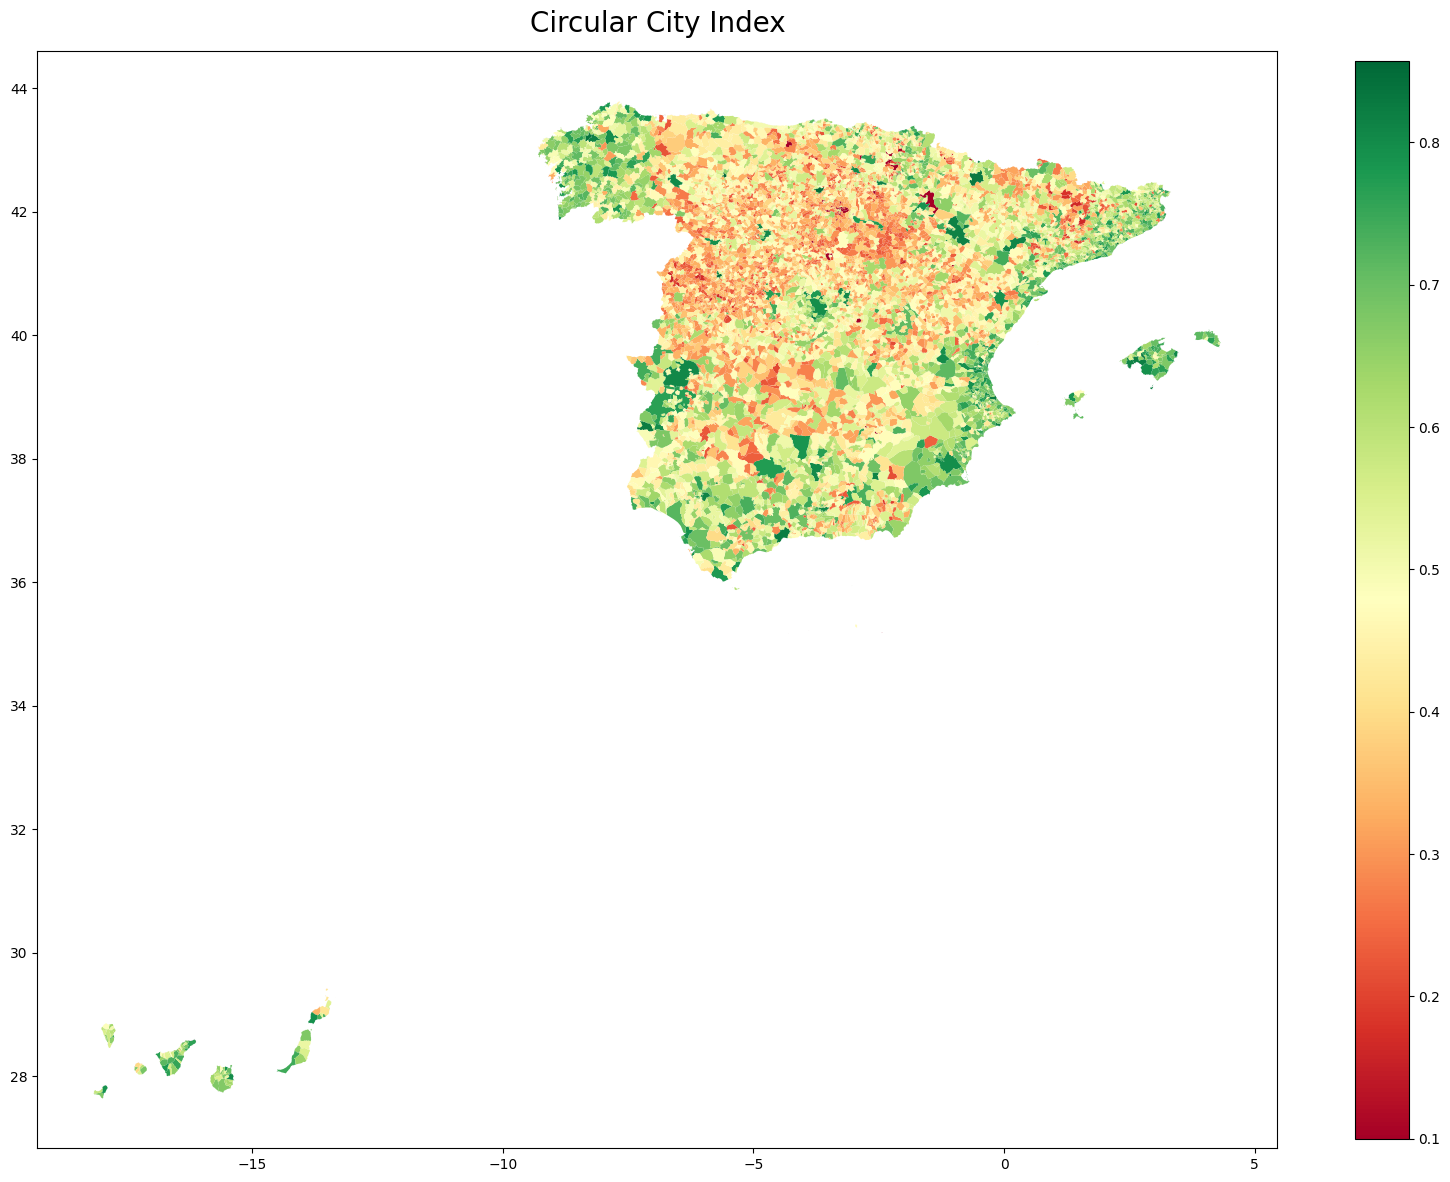

In [21]:
# Plot index results - Circular City Index (Total)
fig, ax = plt.subplots(figsize=(20, 20))

gdf_master.plot(
    ax=ax,
    column="CCI",
    #edgecolor="black",
    legend=True,
    figsize=(20, 20),
    cmap="RdYlGn",
    legend_kwds={"shrink": 0.7},
)

ax.set_title("Circular City Index", fontsize=20, y=1.01)

if SAVE_FIGS is True:
    plt.savefig(DIR_INDEX + "index_results_CCI_total.svg", format="svg")

plt.show()

## Export files

In [23]:
# exports the geodataframe into GeoPackage file
file_name = 'CCI_Index'
data_format = '.gpkg'

export_name = file_name + data_format

if SAVE_INDEX is True:
    gdf_master.to_file(INDEX_FOLDER + export_name, driver='GPKG') 

In [24]:
# exports the geodataframe into Shapefile
file_name = 'CCI_Index'
data_format = '.shp'

export_name = file_name + data_format

if SAVE_INDEX is True:
    gdf_master.to_file(DIR_INDEX + export_name)

In [26]:
# exports the dataframe into csv file
file_name = 'CCI_Index'
data_format = '.csv'

export_name = file_name + data_format

if SAVE_INDEX is True:
    gdf_master.to_csv(DIR_INDEX + export_name)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f11c3f49-2b5e-4e69-9186-d202c2d21fb7' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>